# Hybrid Quantum Neural Networks 

The example below highlights a hybrid quantum neural network workflow with CUDA Quantum and Pytorch where both layers are GPU accelerated to maximise performance. 


<img src="images/hybrid.png" alt="hybrid" width="600">



We perform binary classification on the MNIST dataset where data flows through the neural network architecture to the quantum circuit whose output is used to classify hand written digits.

In [1]:
# Import the relevant packages

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import cudaq
from cudaq import spin

/packages/envs/CUDA-Quantum-0.5.0/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/packages/envs/CUDA-Quantum-0.5.0/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# GPU utilities

cudaq.set_target("nvidia")  # Set CUDAQ to run on GPU's

# If this is True then the NVIDIA drivers are correctly installed
print(f'GPUs Avail: {torch.cuda.is_available()}')

# Counts the number of GPUs available
print(f'GPUs Count: {torch.cuda.device_count()}')  

print(f'Current Device: {torch.cuda.current_device()}')

print(f'Device0 Name: {torch.cuda.get_device_name(0)}')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

GPUs Avail: True
GPUs Count: 4
Current Device: 0
Device0 Name: NVIDIA A100-SXM4-80GB


In [3]:
# Training set
sample_count = 140

X_train = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]),
)

# Leaving only labels 0 and 1
idx = np.append(
    np.where(X_train.targets == 0)[0][:sample_count],
    np.where(X_train.targets == 1)[0][:sample_count],
)

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

# Test set
sample_count = 70

X_test = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]),
)
idx = np.append(
    np.where(X_test.targets == 0)[0][:sample_count],
    np.where(X_test.targets == 1)[0][:sample_count],
)

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

In [4]:
class QuantumCircuit:
    """This class defines the quantum circuit structure and the run method which is used to calculate an expectation value"""

    def __init__(self, qubit_count: int):
        """Define the quantum circuit in CUDA Quantum"""

        kernel, thetas = cudaq.make_kernel(list)

        self.kernel = kernel

        self.theta = thetas

        qubits = kernel.qalloc(qubit_count)

        self.kernel.h(qubits)

        # Variational gate parameters which are optimised during training
        kernel.ry(thetas[0], qubits[0])
        kernel.rx(thetas[1], qubits[0])

    def run(self, thetas: torch.tensor) -> torch.tensor:
        """Excetute the quantum circuit to output an expectation value"""

        expectation = torch.tensor(
          cudaq.observe(
            self.kernel, 
            spin.z(0),
            thetas
          ).expectation(),
          device=device,
        )
        return expectation

In [5]:
class QuantumFunction(Function):
    """Allows the quantum circuit to pass data through it and compute the gradients"""

    @staticmethod
    def forward(ctx, thetas: torch.tensor, quantum_circuit,
                shift) -> torch.tensor:
        # Save shift and quantum_circuit in context to use in backward
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        # Calculate exp_val
        expectations = ctx.quantum_circuit.run(thetas)

        ctx.save_for_backward(thetas, expectations)

        return expectations

    @staticmethod
    def backward(ctx, grad_output):
        """Backward pass computation via finite difference parameter shift"""

        thetas, expectations = ctx.saved_tensors

        gradients = torch.zeros(len(thetas), device=device)

        for i in range(len(thetas)):
            shift_right = torch.clone(thetas)

            shift_right[i] += ctx.shift

            shift_left = torch.clone(thetas)

            shift_left[i] -= ctx.shift

            expectation_right = ctx.quantum_circuit.run(shift_right)
            expectation_left = ctx.quantum_circuit.run(shift_left)

            gradients[i] = 0.5 * (expectation_right - expectation_left)

        return gradients * grad_output.float(), None, None

In [6]:
class QuantumLayer(nn.Module):
    """Encapsulates a quantum circuit and a quantum function into a quantum layer"""

    def __init__(self, shift: torch.tensor):
        super(QuantumLayer, self).__init__()
        self.quantum_circuit = QuantumCircuit(1)  # 1 qubit quantum circuit
        self.shift = shift

    def forward(self, input):
        ans = QuantumFunction.apply(input, self.quantum_circuit, self.shift)

        return ans

In [7]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        # Neural network structure
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(
            64, 2
        )  # Output a 2D tensor since we have 2 variational parameters in our quantum circuit
        self.hybrid = QuantumLayer(
            torch.tensor(np.pi / 2)
        )  # Input is the magnitude of the parameter shifts to calculate gradients

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x).reshape(
            -1)  # Reshapes required to satisfy input dimensions to CUDAQ
        x = self.hybrid(x).reshape(-1)

        return torch.cat((x, 1 - x), -1).unsqueeze(0)

In [8]:
# We move our model to the CUDA device to minimise data transfer between GPU and CPU

model = Net().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_func = nn.NLLLoss().to(device)

epochs = 20

epoch_loss = []

model.train()
for epoch in range(epochs):
    batch_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):  # batch training
        optimizer.zero_grad()

        data, target = data.to(device), target.to(device)

        # Forward pass
        output = model(data).to(device)

        # Calculating loss
        loss = loss_func(output, target).to(device)

        # Backward pass
        loss.backward()

        # Optimize the weights
        optimizer.step()

        batch_loss += loss.item()

    epoch_loss.append(batch_loss / batch_idx)

    print(f"Training [{(epoch+1)/epochs:4.0%}]\tLoss: {epoch_loss[-1]:.4f}")

Training [  5%]	Loss: -1.0946
Training [ 10%]	Loss: -1.3550
Training [ 15%]	Loss: -1.3794
Training [ 20%]	Loss: -1.4184
Training [ 25%]	Loss: -1.4179
Training [ 30%]	Loss: -1.4372
Training [ 35%]	Loss: -1.4377
Training [ 40%]	Loss: -1.4496
Training [ 45%]	Loss: -1.4710
Training [ 50%]	Loss: -1.4759
Training [ 55%]	Loss: -1.4800
Training [ 60%]	Loss: -1.4838
Training [ 65%]	Loss: -1.4842
Training [ 70%]	Loss: -1.4825
Training [ 75%]	Loss: -1.4916
Training [ 80%]	Loss: -1.4824
Training [ 85%]	Loss: -1.4931
Training [ 90%]	Loss: -1.4937
Training [ 95%]	Loss: -1.4957
Training [100%]	Loss: -1.4970


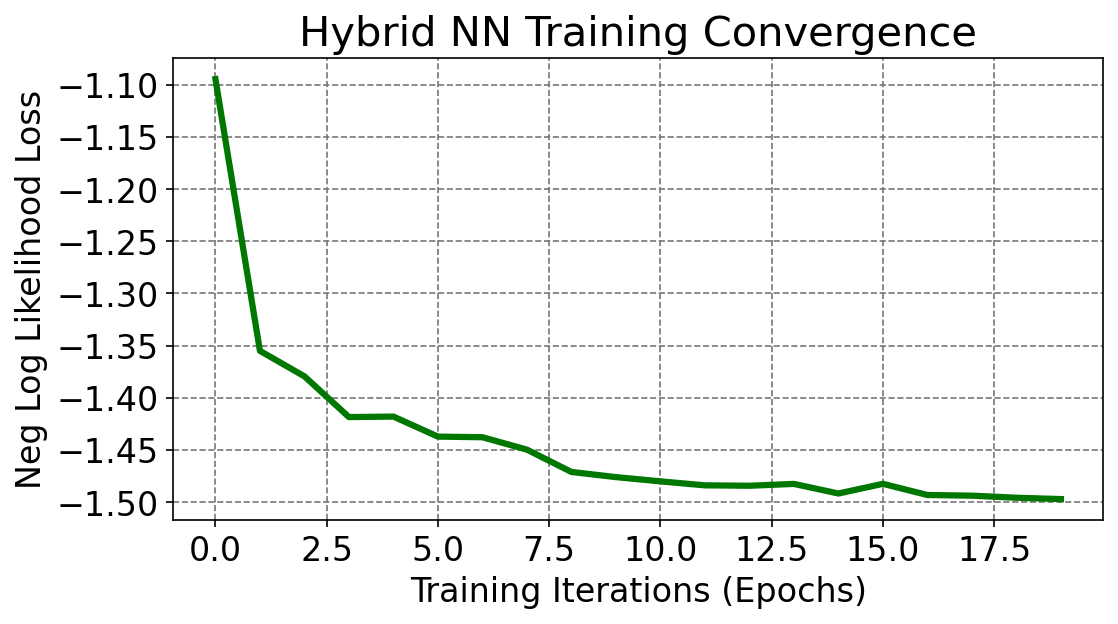

In [9]:
plt.figure(figsize=(8,4),dpi=150)
plt.plot(epoch_loss,'-',c='#070',lw=3)
plt.xlabel("Training Iterations (Epochs)",fontsize=16)
plt.ylabel("Neg Log Likelihood Loss",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Hybrid NN Training Convergence",fontsize=20)
_=plt.grid(which='major',linestyle='--',color='#777')

In [10]:
# Testing on the test set
model.eval()
with torch.no_grad():
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)

        output = model(data).to(device)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        epoch_loss.append(loss.item())
    acc = correct / len(test_loader)
    print(f"Performance on test data:\n\tAccuracy: {acc:.1%}")

Performance on test data:
	Accuracy: 100.0%
